In [2]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import imgkit
import easyocr
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
from typing import List
import json
from torchmetrics import Accuracy
from huggingface_hub import notebook_login
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
pl.seed_everything(42)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


42

## Lets work with images

In [19]:
cd ..

/home


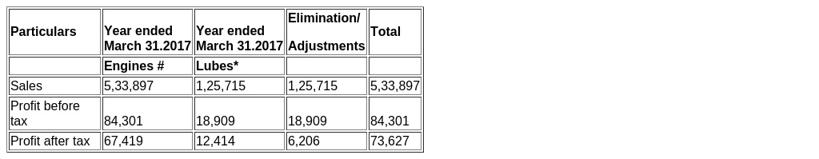

In [28]:
image_paths = sorted(list(Path("data").glob("*/*.jpg")))

image = Image.open(image_paths[2222])
width, height = image.size
image

## Easy OCR

In [29]:
#https://www.jaided.ai/easyocr/documentation/
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [30]:
%%time
image_path = image_paths[2222]
ocr_result = reader.readtext(str(image_path))

CPU times: user 2.94 s, sys: 11.9 s, total: 14.8 s
Wall time: 29.9 s


In [31]:
# Here we can see that the output is each item represents lists of text box coordinates [x,y], text and model confident level, respectively
# we can finetune in our dataset to detect better 
ocr_result

[([[287, 11], [363, 11], [363, 25], [287, 25]],
  'Eliminationl',
  0.997169990907597),
 ([[9, 25], [79, 25], [79, 39], [9, 39]], 'Particulars', 0.7080799158216482),
 ([[103, 23], [175, 23], [175, 39], [103, 39]],
  'Year ended',
  0.7296642756538162),
 ([[195, 23], [267, 23], [267, 39], [195, 39]],
  'Year ended',
  0.9999863912254632),
 ([[369, 25], [405, 25], [405, 39], [369, 39]], 'Total', 0.9998360106546779),
 ([[103, 39], [367, 39], [367, 55], [103, 55]],
  'March 31.2017IMarch 31.2017 Adjustments',
  0.5243422966634623),
 ([[103, 59], [157, 59], [157, 75], [103, 75]], 'Engines', 0.9999983328951281),
 ([[195, 59], [237, 59], [237, 73], [195, 73]], 'Lubes', 0.9999930694352156),
 ([[9, 79], [45, 79], [45, 93], [9, 93]], 'Sales', 0.9999956817256848),
 ([[103, 79], [155, 79], [155, 95], [103, 95]],
  '5,33,897',
  0.5530711490035887),
 ([[195, 79], [249, 79], [249, 93], [195, 93]],
  '1,25,715',
  0.5559478425350883),
 ([[287, 79], [341, 79], [341, 93], [287, 93]],
  '1,25,715',
  0.

In [35]:
def create_bounding_box(bbox_data):
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)

    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))

    return [left, top, right, bottom]

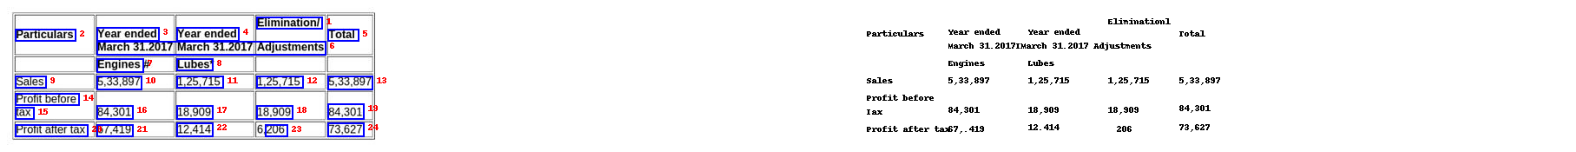

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 28))

left_image = Image.open(image_path).convert("RGB")
right_image = Image.new("RGB", left_image.size, (255, 255, 255))

left_draw = ImageDraw.Draw(left_image)
right_draw = ImageDraw.Draw(right_image)

for i, (bbox, word, confidence) in enumerate(ocr_result):
    
    box = create_bounding_box(bbox)

    left_draw.rectangle(box, outline="blue", width=2)
    left, top, right, bottom = box

    left_draw.text((right + 5, top), text=str(i + 1), fill="red")
    right_draw.text((left, top), text=word, fill="black")

ax1.imshow(left_image)
ax2.imshow(right_image)
ax1.axis("off");
ax2.axis("off");

In [53]:
for image_path in tqdm(image_paths):
    ocr_result = reader.readtext(str(image_path), batch_size=1)

    ocr_page = []
    for bbox, word, confidence in ocr_result:
        ocr_page.append({
            "word": word, "bounding_box": create_bounding_box(bbox)
        })
    break
    with image_path.with_suffix(".json").open("w") as f:
        json.dump(ocr_page, f)

  0%|          | 0/2573 [00:04<?, ?it/s]


In [59]:
image_paths = sorted(list(Path("images").glob("*/*.jpg")))